# Sleep Prediction with Machine Learning

## Project Description
This project aims to build a machine learning model to predict sleep-related metrics, such as sleep duration or quality, based on a given dataset. The notebook explores data preprocessing, model training, hyperparameter tuning, and evaluation to find the best-performing model for this task.

## Notebook Contents
1.  **Data Loading and Initial Exploration:** An overview of the dataset.
2.  **Data Preprocessing and Feature Engineering:** Cleaning the data and preparing it for the model.
3.  **Model Training:** Training various machine learning models (e.g., Logistic Regression, Random Forest, etc.).
4.  **Model Evaluation and Optimization:** Evaluating the performance of the models and finding the best one using metrics like Mean Absolute Error (MAE).
5.  **Final Results:** Displaying the final results and the best-performing model.

# STEP 1: DATA PREPARATION PIPELINE

In [1]:
# ==============================================================================
# Loads data, cleans, engineers features, handles categorical data, splits, 
# imputes remaining NaNs, and scales data for Neural Network input.
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import re

# Set plotting style
sns.set(style="whitegrid")


# The variables X_train_np, X_val_np, X_test_np, y_train_np, y_val_np, y_test_np
# and N_FEATURES are now ready for use in Step 3.

In [2]:
# 1. Load the Dataset
# Use the known file name provided by the user
try:
    df = pd.read_csv('sleep_dataset_modified.csv')
except FileNotFoundError:
    raise FileNotFoundError("Error: 'sleep_dataset_final.csv' not found. Please ensure the file is in the correct directory.")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Sl_no                    150000 non-null  int64  
 1   age                      150000 non-null  int64  
 2   gender                   150000 non-null  object 
 3   bmi                      145331 non-null  float64
 4   caffeine_intake/day(mg)  150000 non-null  int64  
 5   alcohol_intake           150000 non-null  int64  
 6   exercise_duration        150000 non-null  int64  
 7   steps_count              150000 non-null  int64  
 8   screen_time_before_bed   145478 non-null  float64
 9   work_study_hours         150000 non-null  int64  
 10  previous_sleep_duration  145347 non-null  float64
 11  avg_sleep_last_3_days    150000 non-null  float64
 12  sleep_consistency        145417 non-null  float64
 13  resting_heart_rate       150000 non-null  int64  
 14  hear

In [3]:
# 2. Drop Rows with Missing Target Value
# Critical fix to prevent NaN errors in model evaluation
df.dropna(subset=['sleep_duration'], inplace=True)

In [4]:
# 3. Standardize Column Names
# Convert to lowercase and remove special characters for consistent indexing
def clean_column_name(col):
    col = col.lower()
    # Replace non-alphanumeric characters (except underscore) with nothing
    col = re.sub(r'[^a-z0-9_]+', '', col)
    # Handle the specific caffeine column name that results from this cleanup
    if 'caffeineintakedaymg' in col:
        return 'caffeine_intakedaymg'
    return col

df.columns = [clean_column_name(col) for col in df.columns]

In [5]:
# 4. Handle Blood Pressure (String Splitting)
# Convert 'systolic/diastolic' string into two numerical features
# If the column does not exist (e.g., already cleaned in a prior run), skip this
if 'blood_pressure' in df.columns:
    # Attempt to split the string column
    df[['systolic_bp', 'diastolic_bp']] = df['blood_pressure'].str.split('/', expand=True)
    
    # Convert new columns to numeric, setting errors='coerce' turns non-numeric values into NaN
    df['systolic_bp'] = pd.to_numeric(df['systolic_bp'], errors='coerce')
    df['diastolic_bp'] = pd.to_numeric(df['diastolic_bp'], errors='coerce')
    
    # Drop the original string column
    df = df.drop(columns=['blood_pressure'])

In [6]:
# 5. Feature Engineering: Create useful synthetic features
# Use the standardized column names
df['caffeine_per_bmi'] = df['caffeine_intakedaymg'] / df['bmi']

# Drop the columns that were used for feature engineering
df = df.drop(columns=['caffeine_intakedaymg', 'bmi'])

In [7]:
# 6. Drop redundant/non-predictive columns that survived the initial cleaning
df = df.drop(columns=['sl_no']) # Already lowercased

# STEP 2: DATA SPLITTING AND SCALING

In [8]:
# 1. Define Features (X) and Target (y)
X = df.drop(columns=['sleep_duration', 'sleep_consistency', 'previous_sleep_duration']) # sleep_consistency is usually very high
y = df['sleep_duration']


In [9]:
# 2. Handle Categorical Data (One-Hot Encoding)
# This converts 'gender' and 'alcohol_intake' into numerical columns
X = pd.get_dummies(X, columns=['gender', 'alcohol_intake'], drop_first=True)

In [10]:
# 3. Ensure all features are numerical before imputation (CRITICAL RESILIENCE FIX)
# This converts any remaining string/object columns (like bad entries) to numeric, 
# turning non-convertible values into NaNs for the imputer to handle next.
X = X.apply(pd.to_numeric, errors='coerce')

In [11]:
# 4. Data Splitting: Train, Validation, and Test Sets (60% / 20% / 20%)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, test_size=0.25, random_state=42
)

In [12]:
# 5. Imputation (Handling remaining NaNs)
imputer = SimpleImputer(strategy='mean')

# Fit imputer only on the training data and transform all splits
# We must convert the arrays back to DataFrames to retain column names
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [13]:
# 6. Feature Scaling (MinMaxScaler)
scaler = MinMaxScaler()

# Fit the scaler ONLY on the imputed training data
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Transform the validation and test sets using the fitted scaler
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [14]:
# 7. Final preparation for TensorFlow: Convert to NumPy arrays
X_train_np = X_train_scaled.values.astype(np.float32)
X_val_np = X_val_scaled.values.astype(np.float32)
X_test_np = X_test_scaled.values.astype(np.float32)

y_train_np = y_train.values.astype(np.float32)
y_val_np = y_val.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

# Define the number of features for the model (Step 3)
N_FEATURES = X_train_np.shape[1]

In [15]:
# 8. Visualization: Shows the effect of scaling
feature_to_plot = 'stress_level'

# Combine original data for plotting (only 200 samples for clarity)
plot_data_original = X_train[feature_to_plot].sample(200, random_state=42).reset_index(drop=True)
plot_data_scaled = X_train_scaled[feature_to_plot].sample(200, random_state=42).reset_index(drop=True)

plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(0, 0.5, 'Frequency')

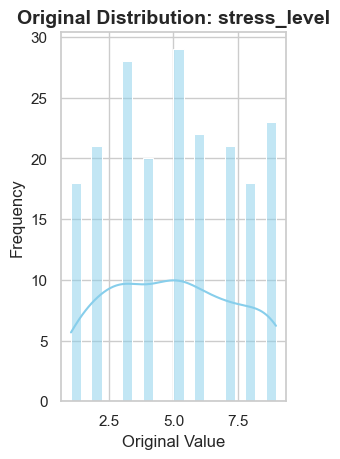

In [16]:
# Subplot 1: Original Distribution
plt.subplot(1, 2, 1)
sns.histplot(plot_data_original, bins=20, kde=True, color='skyblue')
plt.title(f'Original Distribution: {feature_to_plot}', fontsize=14, fontweight='bold')
plt.xlabel('Original Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

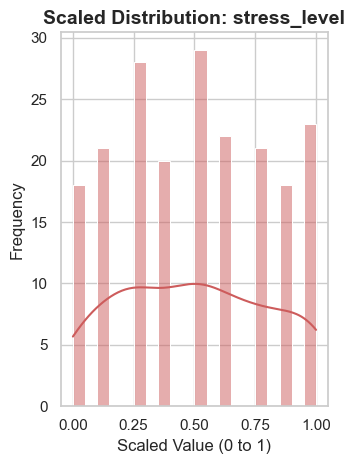

In [17]:
# Subplot 2: Scaled Distribution
plt.subplot(1, 2, 2)
sns.histplot(plot_data_scaled, bins=20, kde=True, color='indianred')
plt.title(f'Scaled Distribution: {feature_to_plot}', fontsize=14, fontweight='bold')
plt.xlabel('Scaled Value (0 to 1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

# The variables X_train_np, X_val_np, X_test_np, y_train_np, y_val_np, y_test_np
# and N_FEATURES are now ready for use in Step 3.

# Step 3: Building and Training the Neural Network (Keras/TensorFlow)

In [18]:
# ==============================================================================
# Goal: Define a simple model, compile it, and train it using the scaled data 
#       (X_train_np, y_train_np) from Step 1 & 2.
# ==============================================================================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [19]:
# --- 1. Variable Check ---
# Ensure variables from the previous step are available.
try:
    # N_FEATURES holds the number of input columns after preprocessing
    N_FEATURES
    X_train_np
    y_train_np
    X_val_np
    y_val_np
except NameError:
    raise NameError("Required variables (N_FEATURES, X_train_np, etc.) from 'step_1_and_2_combined.py' are missing. Please run the data preparation script first.")

In [20]:
# --- 2. Model Architecture Definition ---
# The task is regression (predicting sleep duration, a continuous number).

# Define the optimal input shape based on the processed features
input_shape = (N_FEATURES,) 

model = Sequential([
    # Input Layer (Defines the input shape)
    # The number of neurons (64) is a standard starting point.
    Dense(64, activation='relu', input_shape=input_shape, name='Hidden_1'),
    
    # Dropout Layer (Helps prevent overfitting)
    Dropout(0.2), 
    
    # Second Hidden Layer
    Dense(32, activation='relu', name='Hidden_2'),
    
    # Output Layer
    # Output layer must have 1 neuron for regression. 
    # No activation function (or 'linear') is used for standard regression.
    Dense(1, name='Output_Layer')
], name='Sleep_Duration_Predictor')

C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# --- 3. Model Compilation ---

# We use the Adam optimizer and Mean Squared Error (MSE) loss, standard for regression.
# Metrics: MAE (Mean Absolute Error) is more interpretable than MSE.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Display the model summary to confirm the architecture and parameters
model.summary()

Model: "Sleep_Duration_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_1 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_2 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# --- 4. Callbacks (For robust training) ---

# Early Stopping: Stop training when validation loss stops improving.
# Patience means waiting 10 epochs before stopping.
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# Reduce LR on Plateau: Reduce learning rate if validation loss plateaus.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=0.00001
)

In [23]:
# --- 5. Model Training ---

EPOCHS = 100
BATCH_SIZE = 32

print("\n--- Starting Model Training ---\n")

history = model.fit(
    X_train_np,
    y_train_np,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_np, y_val_np),
    callbacks=[early_stopping, reduce_lr],
    verbose=1 # Show training progress
)


--- Starting Model Training ---

Epoch 1/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.7860 - mae: 0.8633 - val_loss: 0.1243 - val_mae: 0.2862 - learning_rate: 0.0010
Epoch 2/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2342 - mae: 0.3498 - val_loss: 0.0472 - val_mae: 0.1737 - learning_rate: 0.0010
Epoch 3/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0846 - mae: 0.1893 - val_loss: 0.0332 - val_mae: 0.1010 - learning_rate: 0.0010
Epoch 4/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0182 - mae: 0.0785 - val_loss: 0.0403 - val_mae: 0.1041 - learning_rate: 0.0010
Epoch 5/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0113 - mae: 0.0619 - val_loss: 0.0377 - val_mae: 0.0978 - learning_rate: 0.0010
Epoch 6/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0087 - mae: 0.0545 - val_loss: 0.0548 - val_mae: 0.1339 - learning_rate: 0.0010
Epoch 7/100
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0079 - mae: 0.0517 - val_loss

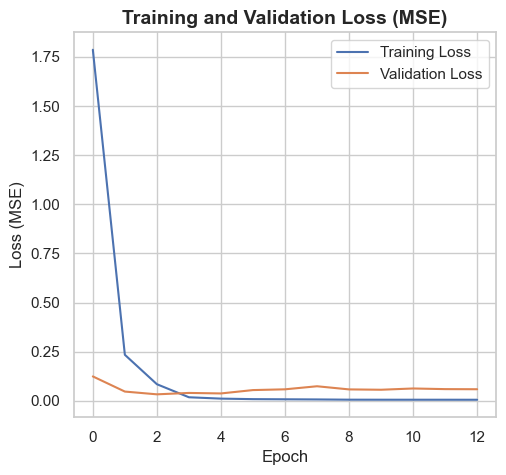

In [24]:
# --- 6. Visualization of Training History ---

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (MSE)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

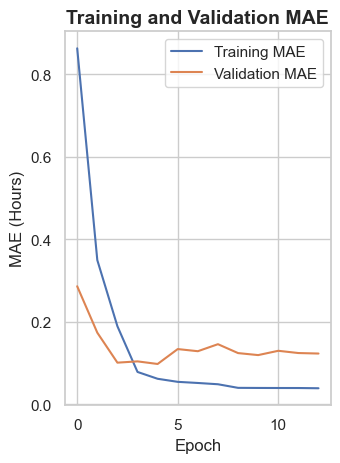

In [25]:
# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MAE (Hours)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Final trained model is stored in the 'model' variable.

# Step 4: Model Evaluation and Prediction

In [26]:
# ==============================================================================
# Goal: Evaluate the trained model's performance on the test set and visualize 
#       predictions against actual values.
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [27]:
# --- 1. Variable Check ---

# Ensure variables from the previous steps are available.
try:
    model
    X_test_np
    y_test_np
except NameError:
    raise NameError("Required variables (model, X_test_np, y_test_np) are missing. Please run the combined data preparation script (Step 1 & 2) and the training script (Step 3) first.")

In [28]:
# --- 2. Model Evaluation on Test Data ---

# Use the evaluate method to get the final loss (MSE) and MAE on the test set.
print("--- Evaluating Model Performance on Test Set ---\n")
test_loss, test_mae = model.evaluate(X_test_np, y_test_np, verbose=0)

print(f"Test Mean Squared Error (MSE): {test_loss:.4f}")
print(f"Test Mean Absolute Error (MAE): {test_mae:.4f} hours")
print(f"Interpretation: On average, the model's predictions are off by {test_mae:.2f} hours.\n")

--- Evaluating Model Performance on Test Set ---

Test Mean Squared Error (MSE): 0.0345
Test Mean Absolute Error (MAE): 0.1024 hours
Interpretation: On average, the model's predictions are off by 0.10 hours.



In [29]:
# --- 3. Predictions ---

# Generate predictions for the test set
y_pred_np = model.predict(X_test_np, verbose=0)

# Reshape the prediction array to match the target array (from [N, 1] to [N,])
y_pred = y_pred_np.flatten()
y_true = y_test_np.flatten()

In [30]:
# --- 4. Additional Regression Metrics (Scikit-learn) ---

# Calculate R-squared value to understand the variance explained
r2 = r2_score(y_true, y_pred)
print(f"R-squared (R²): {r2:.4f}")

R-squared (R²): 0.9689


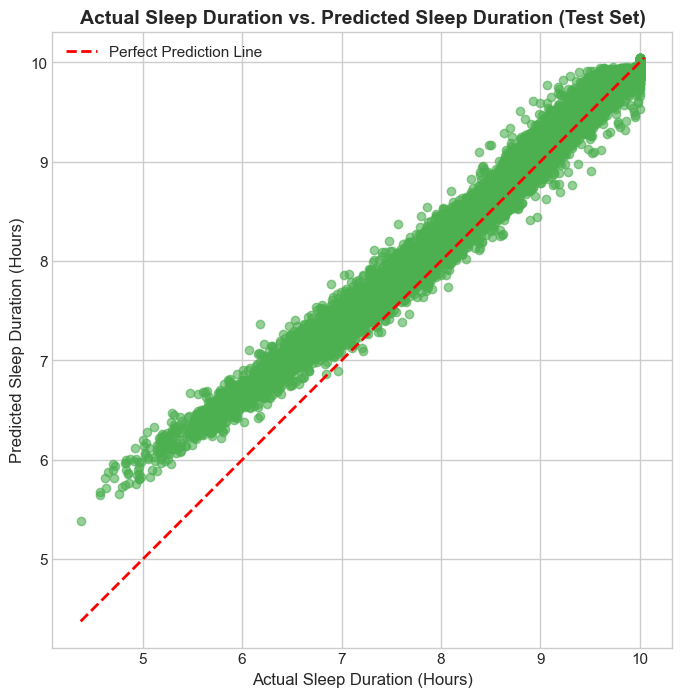

In [31]:
# --- 5. Visualization: Actual vs. Predicted ---

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 8))

# Scatter plot of actual vs. predicted values
plt.scatter(y_true, y_pred, alpha=0.6, color='#4CAF50')

# Plot the ideal 'y=x' line (where prediction equals actual)
max_val = max(y_true.max(), y_pred.max())
min_val = min(y_true.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction Line')

plt.title('Actual Sleep Duration vs. Predicted Sleep Duration (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Actual Sleep Duration (Hours)', fontsize=12)
plt.ylabel('Predicted Sleep Duration (Hours)', fontsize=12)
plt.legend()
plt.axis('equal') # Ensure the axes have the same scale
plt.grid(True)
plt.show()

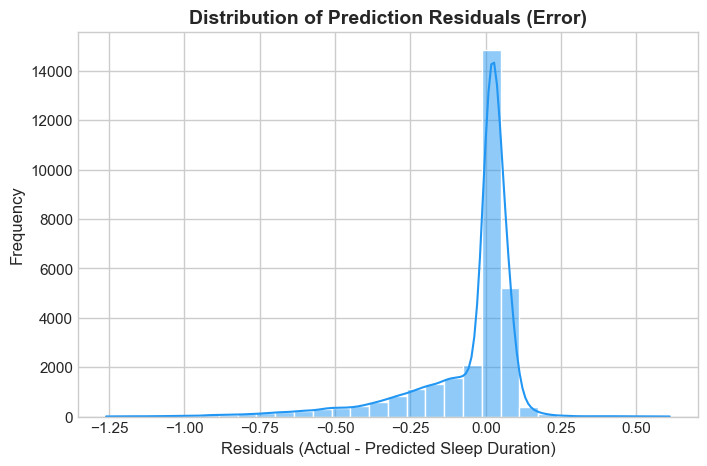

In [32]:
# --- 6. Visualization: Residuals Distribution ---

residuals = y_true - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='#2196F3')
plt.title('Distribution of Prediction Residuals (Error)', fontsize=14, fontweight='bold')
plt.xlabel('Residuals (Actual - Predicted Sleep Duration)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

# Step 5: Model Optimization (Hyperparameter Tuning)

In [33]:
# ==============================================================================
# Goal: Systematically adjust model architecture and training settings 
#       (hyperparameters) to improve performance (i.e., lower Test MAE).
# ==============================================================================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

In [34]:
# --- 1. Variable Check ---
try:
    N_FEATURES
    X_train_np
    y_train_np
    X_val_np
    y_val_np
    X_test_np
    y_test_np
except NameError:
    raise NameError("Required variables (N_FEATURES, X_train_np, etc.) are missing. Please run the combined data preparation script (Step 1 & 2) first.")

In [35]:
# --- 2. Define the Optimized Model Creation Function ---

def create_optimized_model(input_dim, layers, dropout_rate, learning_rate):
    """Creates a Keras Sequential model with customizable architecture."""
    model = Sequential(name='Optimized_Sleep_Predictor')

    # Input Layer and First Hidden Layer
    model.add(Dense(layers[0], activation='relu', input_shape=(input_dim,), name='Input_Hidden_1'))
    model.add(Dropout(dropout_rate))

    # Additional Hidden Layers
    for i, units in enumerate(layers[1:]):
        model.add(Dense(units, activation='relu', name=f'Hidden_{i+2}'))

    # Output Layer (1 neuron, linear activation for regression)
    model.add(Dense(1, name='Output_Layer'))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

In [36]:
# --- 3. Define Hyperparameter Search Space ---
# We will test a small, representative set of hyperparameters.
HYPERPARAMETERS = [
    # Baseline Model (similar to Step 3)
    {'layers': [64, 32], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32},
    
    # Deeper Model (more layers)
    {'layers': [64, 64, 32, 16], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32},
    
    # Wider Model (more units in the first layer)
    {'layers': [128, 64, 32], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64},
    
    # Lower Learning Rate (finer adjustments during training)
    {'layers': [64, 32], 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 32},
]

In [ ]:
# --- 5. Final Results ---

print("==============================================")
print("             Optimization Results             ")
print("==============================================")
print(f"BEST TEST MAE: {best_mae:.4f} hours")
print("BEST HYPERPARAMETERS:")
for key, value in best_params.items():
    print(f"  - {key}: {value}")
    
# The best model is stored in the 'best_model' variable for further use.